In [37]:
from sqlalchemy import create_engine
import pyedflib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

In [38]:
DB_NAME="biosignal_db"
DB_USER="student"
DB_PASSWORD="password"
DB_HOST="localhost"
DB_PORT="5432"

In [39]:
engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

In [40]:
n_signals = []
signal_labels = []
sigbufs = []
edf_path = "abdominal/r01.edf"

In [41]:
with pyedflib.EdfReader(edf_path) as edf_reader:
    n_signals = edf_reader.signals_in_file
    signal_labels = [edf_reader.getLabel(i) for i in range(n_signals)]
    sigbufs = [edf_reader.readSignal(i) for i in range(n_signals)]

In [42]:
df = pd.DataFrame(sigbufs).T
df.columns = signal_labels
sample_rate = int(edf_reader.getSampleFrequency(0))
df['timestamp'] = df.index / sample_rate

In [43]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [44]:
print("Number of NaN:", df.isna().sum())
df_clean = df.dropna()
print("Number of NaN after cleanup:", df_clean.isna().sum())
print("Sample Rate", sample_rate)

Number of NaN: Direct_1     0
Abdomen_1    0
Abdomen_2    0
Abdomen_3    0
Abdomen_4    0
timestamp    0
dtype: int64
Number of NaN after cleanup: Direct_1     0
Abdomen_1    0
Abdomen_2    0
Abdomen_3    0
Abdomen_4    0
timestamp    0
dtype: int64
Sample Rate 1000


In [45]:
print("First 5 rows:\n", df.head())
print("Stats by columns:\n", df.describe())

First 5 rows:
     Direct_1  Abdomen_1  Abdomen_2  Abdomen_3  Abdomen_4  timestamp
0  28.750439  -8.850135  13.350204  22.050336  32.550497      0.000
1  26.650407 -13.950213  12.650193  21.750332  35.350539      0.001
2  24.750378 -18.750286  12.050184  21.250324  37.550573      0.002
3  23.750362 -23.450358  11.450175  20.250309  38.950594      0.003
4  23.550359 -27.950426  10.450159  18.550283  39.450602      0.004
Stats by columns:
             Direct_1      Abdomen_1      Abdomen_2      Abdomen_3  \
count  300000.000000  300000.000000  300000.000000  300000.000000   
mean        0.340427       0.031705       0.028497       0.052548   
std        43.415497      20.946853      27.875419      15.986189   
min      -216.553304    -172.052625    -154.652360     -94.351440   
25%       -24.150369      -7.350112      -9.650147      -4.750072   
50%        -2.050031       2.050031      -0.150002      -0.250004   
75%        22.950350       9.050138       9.650147       4.650071   
max   

In [46]:
abdomen_channels = ['Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
abdomen_df = df[abdomen_channels]
abdomen_df.head()

,Abdomen_1,Abdomen_2,Abdomen_3,Abdomen_4
0,-8.850135,13.350204,22.050336,32.550497
1,-13.950213,12.650193,21.750332,35.350539
2,-18.750286,12.050184,21.250324,37.550573
3,-23.450358,11.450175,20.250309,38.950594
4,-27.950426,10.450159,18.550283,39.450602


In [47]:
df['Abdomen_mean'] = abdomen_df.mean(axis=1)
df['Abdomen_mean'].head()

0    14.775225
1    13.950213
2    13.025199
3    11.800180
4    10.125154
Name: Abdomen_mean, dtype: float64

In [48]:
df_filtered = df[df['Direct_1']> 25]
print(df_filtered.head())

     Direct_1  Abdomen_1  Abdomen_2  Abdomen_3  Abdomen_4  timestamp  \
0   28.750439  -8.850135  13.350204  22.050336  32.550497      0.000   
1   26.650407 -13.950213  12.650193  21.750332  35.350539      0.001   
10  25.350387 -57.550878  -5.350082  -0.050001  35.250538      0.010   
11  26.450404 -59.550909  -6.450098  -1.650025  33.450510      0.011   
12  27.350417 -60.450922  -6.750103  -2.550039  31.550481      0.012   

    Abdomen_mean  
0      14.775225  
1      13.950213  
10     -6.925106  
11     -8.550130  
12     -9.550146  


In [49]:
df['second']=df['timestamp'].astype(int)
df_grouped = df.groupby('second')[abdomen_channels].mean()
df_grouped.head()

,Abdomen_1,Abdomen_2,Abdomen_3,Abdomen_4
second,,,,
0,-3.071447,-4.431968,0.768512,1.774627
1,1.549524,1.985530,-0.193803,0.569609
2,-2.697341,-4.917375,-1.861528,-0.783712
3,0.739011,2.672341,2.524739,0.597309
4,4.398467,1.674726,-0.384306,-0.113902


In [50]:
A = df.to_numpy()
mean = np.mean(A, axis=0)
std = np.std(A, axis=0)
print("Mean:", mean)
print("STD:", std)      

Mean: [3.40426528e-01 3.17048171e-02 2.84967682e-02 5.25478018e-02
 5.98129127e-02 1.49999500e+02 4.31405749e-02 1.49500000e+02]
STD: [43.41542484 20.94681842 27.87537207 15.98616278 19.59429027 86.60254038
 12.03672456 86.60205925]


In [51]:
N = -1 + 2*(A-A.min())/(A.max()-A.min())
N

array([[-0.07903135, -0.22019899, -0.13685001, ..., -0.18697203,
        -0.13149991, -0.18697203],
       [-0.08691571, -0.23934672, -0.13947813, ..., -0.18696827,
        -0.13459733, -0.18697203],
       [-0.09404918, -0.25736812, -0.14173081, ..., -0.18696452,
        -0.13807021, -0.18697203],
       ...,
       [ 0.00469307, -0.15336963, -0.18640886, ...,  0.93933705,
        -0.17739816,  0.93559391],
       [ 0.00394218, -0.15336963, -0.18528252, ...,  0.9393408 ,
        -0.17627182,  0.93559391],
       [ 0.00431763, -0.15299418, -0.18453163, ...,  0.93934456,
        -0.17533321,  0.93559391]], shape=(300000, 8))

In [52]:
plt.plot(df['timestamp'], df['Direct_1'], label='Direct_1')
plt.plot(df['timestamp'], df['Abdomen_1'], label='Abdomenal 1')
plt.plot(df['timestamp'], df['Abdomen_2'], label='Abdomenal 2')
plt.plot(df['timestamp'], df['Abdomen_3'], label='Abdomenal 3')
plt.plot(df['timestamp'], df['Abdomen_4'], label='Abdomenal 4')
plt.legend()
plt.grid()
plt.show()

"plt.plot(df['timestamp'], df['Direct_1'], label='Direct_1')\nplt.plot(df['timestamp'], df['Abdomen_1'], label='Abdomenal 1')\nplt.plot(df['timestamp'], df['Abdomen_2'], label='Abdomenal 2')\nplt.plot(df['timestamp'], df['Abdomen_3'], label='Abdomenal 3')\nplt.plot(df['timestamp'], df['Abdomen_4'], label='Abdomenal 4')\nplt.legend()\nplt.grid()\nplt.show()"

In [53]:
t = df['timestamp'][:2000].values
signal = df['Abdomen_4'][:2000].values
plt.plot(t, signal, label="Abdomenal 4 (zoomed")
plt.legend()
plt.grid()
plt.show()

'plt.plot(t, signal, label="Abdomenal 4 (zoomed")\nplt.legend()\nplt.grid()\nplt.show()'

In [54]:
b, a = butter(16, 0.1, btype='low', analog=False)
filtered = filtfilt(b, a, signal)
plt.plot(t, signal, label='Abdomenal 4')
plt.plot(t, filtered, label='Low Frequency harmonics')
plt.legend()
plt.grid()
plt.show()

"plt.plot(t, signal, label='Abdomenal 4')\nplt.plot(t, filtered, label='Low Frequency harmonics')\nplt.legend()\nplt.grid()\nplt.show()"

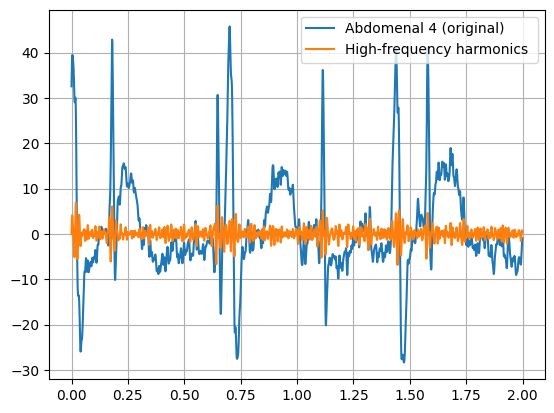

In [55]:
h = signal - filtered
plt.plot(t, signal, label='Abdomenal 4 (original)')
plt.plot(t, h, label='High-frequency harmonics ')
plt.legend()
plt.grid()
plt.show()